Using batoid to study HSC telescope optics. \
This notebook is largely based on examples in https://github.com/jmeyers314/batoid/tree/releases/0.3/notebook

In [6]:

import batoid
import yaml
import os
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [7]:
# The SST optics are _slightly_ different for the different filters.
# Here we load the configuration for r-band, but for the purposes
# of getting a good distribution of incident angles, I don't think
# changing this will make much difference.
telescope = batoid.Optic.fromYaml("HSC.yaml")

In [8]:
from mpl_toolkits import mplot3d

In [9]:
# Sanity check optic shifting
@interact(optic=widgets.Dropdown(
              options=['SubaruHSC.HSC.WFC.G1',
                       'SubaruHSC.HSC.WFC.G2',                       
                       'SubaruHSC.HSC.WFC.ADC',
                       'SubaruHSC.HSC.WFC.ADC.ADC1',
                       'SubaruHSC.HSC.WFC.ADC.ADC2',
                       'SubaruHSC.HSC.WFC.G3',
                       'SubaruHSC.HSC.WFC.G4',
                       'SubaruHSC.HSC.WFC.G5',
                       'SubaruHSC.HSC.CAM.F',
                       'SubaruHSC.HSC.CAM.W',
                       'SubaruHSC.HSC.CAM.D'],
              default='SubaruHSC.HSC.WFC.ADC'
          ),
          gdx=widgets.FloatSlider(min=-1, max=1, step=0.01, value=0.2),
          gdy=widgets.FloatSlider(min=-1, max=1, step=0.01, value=0.0),
          gdz=widgets.FloatSlider(min=-1, max=1, step=0.01, value=0.0),
          dthx=widgets.FloatSlider(min=-90, max=90, step=5, value=0.0),
          dthy=widgets.FloatSlider(min=-90, max=90, step=5, value=0.0),
          dthz=widgets.FloatSlider(min=-90, max=90, step=5, value=0.0),
          ldx=widgets.FloatSlider(min=-1, max=1, step=0.01, value=0.0),
          ldy=widgets.FloatSlider(min=-1, max=1, step=0.01, value=0.0),
          ldz=widgets.FloatSlider(min=-1, max=1, step=0.01, value=0.0),
         )
def shiftOptic(optic, gdx, gdy, gdz, dthx, dthy, dthz, ldx, ldy, ldz):
    rot = batoid.RotZ(np.pi/180*dthz).dot(batoid.RotX(np.pi/180*dthx)).dot(batoid.RotY(np.pi/180*dthy))
    perturbedTelescope = telescope.withGloballyShiftedOptic(optic, [gdx, gdy, gdz])
    perturbedTelescope = perturbedTelescope.withLocallyRotatedOptic(optic, rot)
    perturbedTelescope = perturbedTelescope.withLocallyShiftedOptic(optic, [ldx, ldy, ldz])
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    perturbedTelescope['SubaruHSC.HSC'].draw3d(ax, c='k')
    #And redraw the perturbed optic in red
    perturbedTelescope[optic].draw3d(ax, c='r')
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)    
    ax.set_zlim(13.5, 15.25)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")    
    plt.show()

interactive(children=(Dropdown(description='optic', options=('SubaruHSC.HSC.WFC.G1', 'SubaruHSC.HSC.WFC.G2', '…

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv

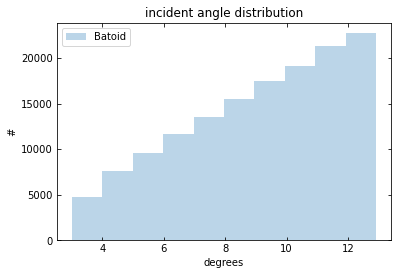

In [11]:
thx = np.deg2rad(0.0)
thy = np.deg2rad(0.0)
wavelength = 900e-9 # meters
rays = batoid.RayVector.asPolar(
    optic=telescope,
    wavelength=wavelength,
    theta_x=thx, theta_y=thy,
    nrad=1000, naz=300  #  These control how many parallel rays are created
)

tf = telescope.traceFull(rays[np.random.choice(len(rays), 20)])
# Now trace through the system
telescope.trace(rays)
# Limit to unvignetted rays
#rays = rays[~rays.vignetted]
rays= rays[~rays.vignetted]

dxdz = rays.vx/rays.vz
dydz = rays.vy/rays.vz
#plt.hist(np.arctan(np.sqrt(dxdz**2+dydz**2))*180/np.pi,label = 'Fringing')

# We can convert these to a 1d histogram of incident angles
inc_thx, inc_thy = batoid.utils.dirCosToField(rays.vx, rays.vy, -rays.vz)
plt.hist(np.rad2deg(np.hypot(inc_thx, inc_thy)),label = 'Batoid',alpha = 0.3)
plt.xlabel("degrees")
plt.ylabel("#")
plt.legend(loc = 'best')
plt.title("incident angle distribution");

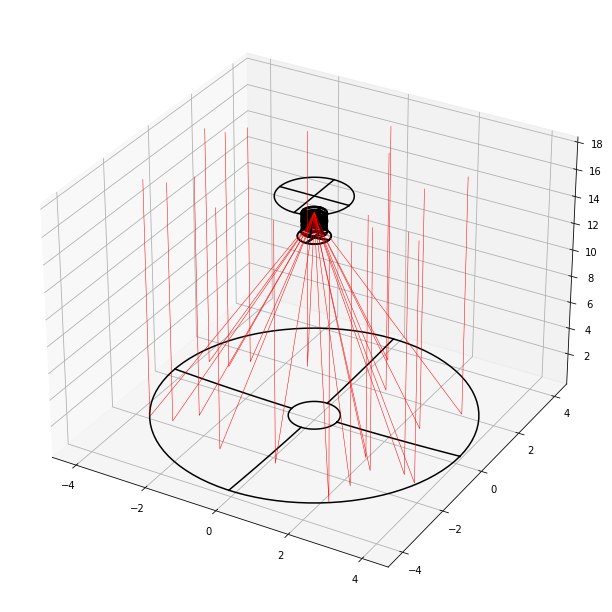

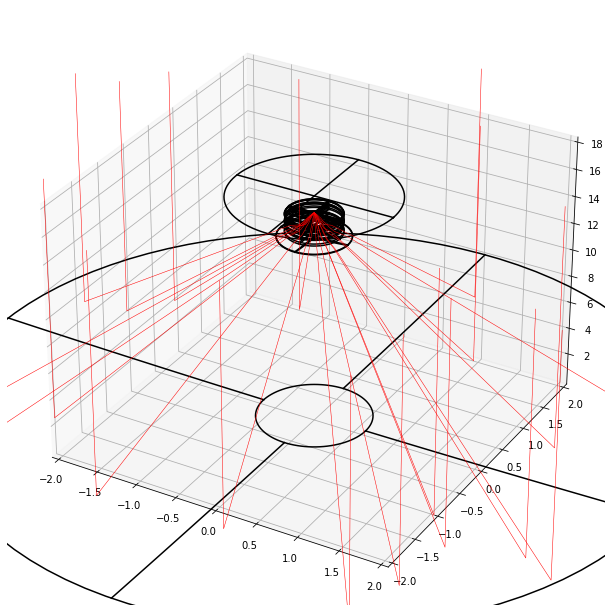

In [19]:
# We can visualize all of this too:
fig = plt.figure(figsize=(12, 11))
ax = fig.add_subplot(111, projection='3d')
#ax.set_xlim(-5, 5)
#ax.set_ylim(-5, 5)
#ax.set_zlim(0, 10)
telescope.draw3d(ax, c='k')
batoid.drawTrace3d(ax, tf, c='r', lw=0.5)
plt.show()

# Zoom in on sensor
#sensorZ = telescope['Detector'].coordSys.origin[2]
fig = plt.figure(figsize=(12, 11))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
#ax.set_zlim(sensorZ - 0.5, sensorZ + 0.5)
telescope.draw3d(ax, c='k')
batoid.drawTrace3d(ax, tf, c='r', lw=0.5)
plt.show()

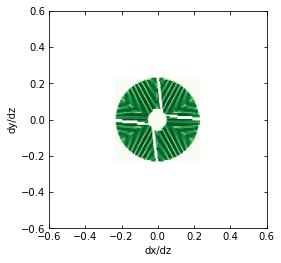

In [20]:
# Plot distribution of incident dxdz and dydz.
plt.figure(figsize = (4,4))
dxdz = rays.vx/rays.vz
dydz = rays.vy/rays.vz
#plt.title('Incident Slope distribution',fontsize = 15)
plt.hexbin(
    dxdz, dydz, 
    reduce_C_function=np.sum,cmap=plt.cm.Greens
)

#plt.axhline(0., c='r',alpha = 0.3)
#plt.axvline(0., c='r',alpha = 0.3)
plt.gca().set_aspect("equal")
plt.xlabel("dx/dz")
plt.ylabel("dy/dz")
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.show()

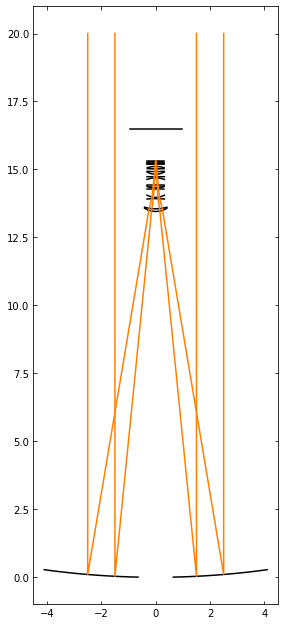

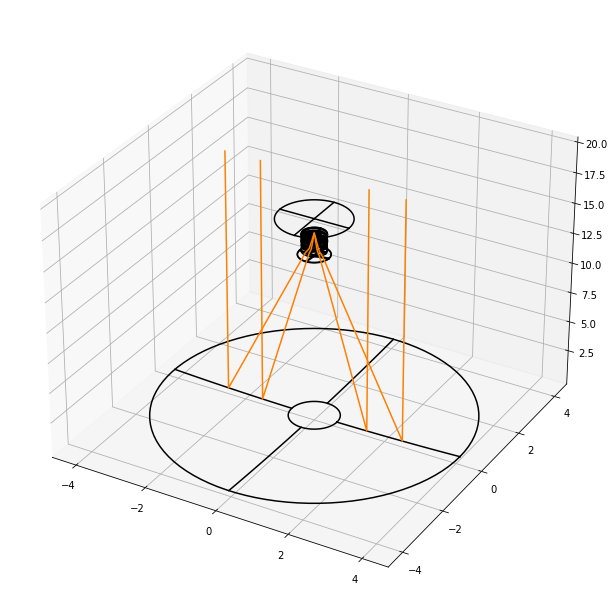

In [21]:
fig1 = plt.figure(figsize=(12, 11))
ax1 = fig1.add_subplot(111)
telescope.draw2d(ax1, c='k')

fig2 = plt.figure(figsize=(12, 11))
ax2 = fig2.add_subplot(111, projection='3d')
telescope.draw3d(ax2, c='k')

ipv.figure(width=700, height=500)
telescope.draw3d(ipv, color='black')

x = np.array([-2.5, -1.5, 1.5, 2.5])

for vx, c in zip(np.deg2rad([ 0]), [ '#ff7f00']):
    rays = batoid.RayVector(x, 0, 0, vx, 0, -np.sqrt(1-vx**2), wavelength=900e-9)
    rays.propagate(-20)
    tF = telescope.traceFull(rays)
    batoid.drawTrace2d(ax1, tF, c=c)
    batoid.drawTrace3d(ax2, tF, c=c)
    batoid.drawTrace3d(ipv, tF, color=c)
ax1.set_aspect('equal')
ipv.show()

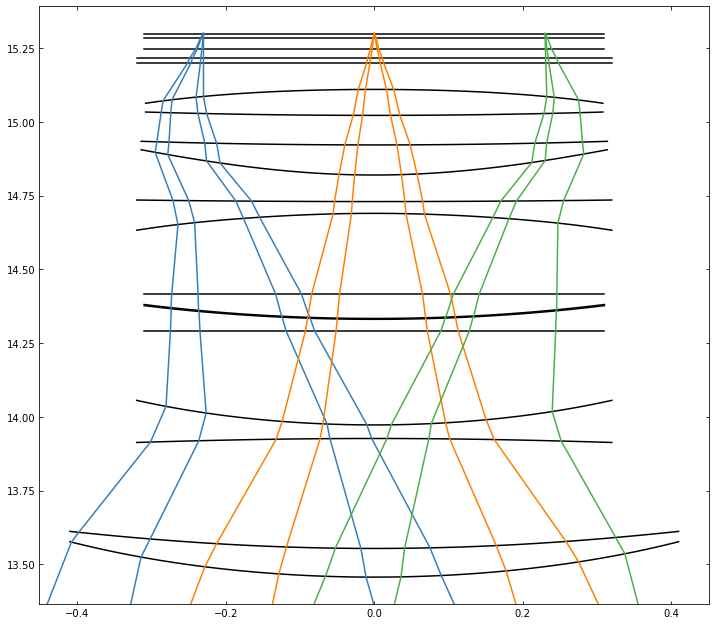

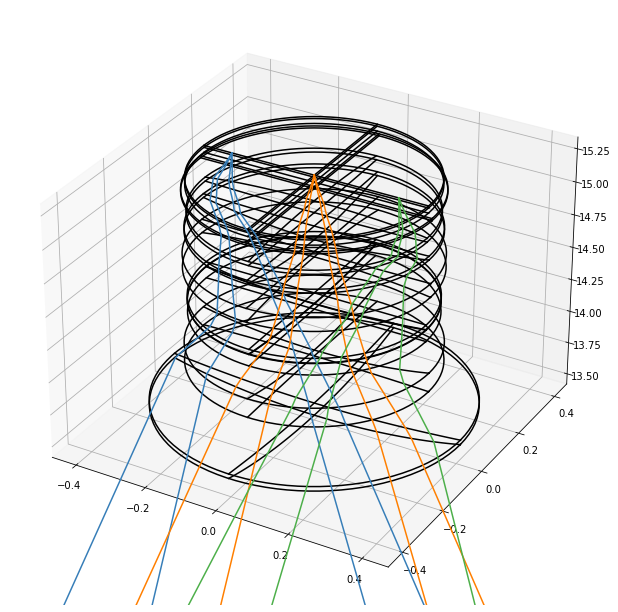

In [22]:
fig1 = plt.figure(figsize=(12, 11))
ax1 = fig1.add_subplot(111)
telescope['HSC'].draw2d(ax1, c='k')
ax1.set_xlim(ax1.get_xlim())
ax1.set_ylim(ax1.get_ylim())

fig2 = plt.figure(figsize=(12, 11))
ax2 = fig2.add_subplot(111, projection='3d')
telescope['HSC'].draw3d(ax2, c='k')
ax2.set_xlim(ax2.get_xlim())
ax2.set_ylim(ax2.get_ylim())
ax2.set_zlim(ax2.get_zlim())

ipv.figure(width=700, height=500)
telescope.draw3d(ipv, color='black')

x = np.array([-2.5, -1.5, 1.5, 2.5])

for vx, c in zip(np.deg2rad([-0.7, 0, 0.7]), ['#377eb8', '#ff7f00', '#4daf4a']):
    rays = batoid.RayVector(x, 0, 0, vx, 0, -np.sqrt(1-vx**2), wavelength=500e-9)
    rays.propagate(-20)
    tF = telescope.traceFull(rays)
    batoid.drawTrace2d(ax1, tF, c=c)
    batoid.drawTrace3d(ax2, tF, c=c)
    batoid.drawTrace3d(ipv, tF, color=c)
ipv.xlim(-0.5, 0.5)
ipv.ylim(-0.5, 0.5)
ipv.zlim(13.4, 15.4)
ipv.show()